# Twitter trolls - how Russia meddles with western democracies


## Abstract
Over the last several years there has been an attempt from Russian trolls to spread propaganda and fake news over social media in order to spread political ideas among the general population both nationally and internationally. Can these attempts be regarded as undermining the democracy of the affected countries?

In this project we are going to analyze a great number of these russian tweets and look into their motivations for this meddling. We will mainly look into their overall political goals in the US, and examine how these goals change over time. Have the trolls achieved their goals? We will also look into how the trolls operate and organize themselves, trying to find patterns in the madness. Such patterns can hopefully help the general population to indicate that a tweet is originating from a troll. As the Russian efforts are increasing every year, a solution is needed to defend the democracy.

### Imports used in this notebook


In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import scipy as sp
from pyspark.sql import *
import matplotlib.pyplot as plt
from statistics import median 
from langdetect import detect
%matplotlib inline
from datetime import datetime
from pyspark.sql.functions import *
from pyspark.sql.types import *
from matplotlib.pyplot import figure
#import pyspark.sql.SQLContext
from ipywidgets import *
import pyspark.sql.functions as func
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#Want to ignore this since we had the same error running over and over regarding to whether use loc or make a copy. In our notebook the difference does not matter.

spark = SparkSession.builder.getOrCreate()

# 1) Preprocessing the data
The data sets are of different shape and quality. The first one, provided by two researchers from Clemson University has already been preprocessed a bit. The second one is still quite raw, even though it has certain features as for example language. We have been cleaning some of it, and also processing and enriching to make new data frames that we want to use in our analysis.

## 1.1) The first dataset - IRA tweets from Kaggle.
The first dataset has the following features:
- external_author_id | An author account ID from Twitter 
- author | The handle sending the tweet
- content | The text of the tweet
- region | A region classification based on following criterias:
     - 1. Geographical coordinates
     - 2. Location listed in the user's profile
     - 3. Time zone set by the user in their Twitter account settings.
- language | The language of the tweet
- publish_date | The date and time the tweet was sent
- harvested_date | The date and time the tweet was collected by Social Studio
- following | The number of accounts the handle was following at the time of the tweet
- followers | The number of followers the handle had at the time of the tweet
- updates | The number of “update actions” on the account that authored the tweet, including tweets, retweets and likes
- post_type | Indicates if the tweet was a retweet or a quote-tweet
- account_type | Specific account theme, as coded by Linvill and Warren
- retweet | A binary indicator of whether or not the tweet is a retweet
- account_category` | General account theme, as coded by Linvill and Warren
- new_june_2018 | A binary indicator of whether the handle was newly listed in June 2018


### 1.1.1) Loading the first dataset
We loaded the 9 files into a unified dataframe. We decided to use pandas, since the dataset is not too large, and especially with the fact that we will be focusing on subsets of these tweets.

In [201]:
zip_file = ZipFile('russian-troll-tweets.zip')
data = pd.DataFrame()
for i in range(1,9):
    data = data.append(pd.read_csv(zip_file.open("IRAhandle_tweets_"+str(i)+".csv")))
first_set_data=data.reset_index()
first_set_data.tail(5)

,index,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
2935811,378290,1.513801e+09,YOUJUSTCTRLC,They'll say some shit anonymously like a cowar...,United States,English,1/7/2017 7:47,1/7/2017 7:48,2655,2724,3007,RETWEET,left,0,1,LeftTroll
2935812,378291,1.513801e+09,YOUJUSTCTRLC,Mr. Brown knees https://t.co/LmAiHCnFlz,United States,English,1/7/2017 7:47,1/7/2017 7:48,2655,2724,3006,RETWEET,left,0,1,LeftTroll
2935813,378292,1.513801e+09,YOUJUSTCTRLC,"Like, you want somebody who follows you regula...",United States,English,1/7/2017 7:47,1/7/2017 7:47,2655,2724,3005,RETWEET,left,0,1,LeftTroll
2935814,378293,1.513801e+09,YOUJUSTCTRLC,"If you wanna ask me something, ask it here so ...",United States,English,1/7/2017 7:48,1/7/2017 7:48,2655,2724,3008,RETWEET,left,0,1,LeftTroll
2935815,378294,1.513801e+09,YOUJUSTCTRLC,And there he is again ... Inside the KGB Playb...,United States,English,1/8/2017 1:56,1/8/2017 1:57,2655,2724,3013,RETWEET,left,0,1,LeftTroll


In [202]:
first_set_data.head(5)

,index,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,0,RightTroll
1,1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,0,RightTroll
2,2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,0,1,RightTroll
3,3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,0,RightTroll
4,4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,0,1,RightTroll


### 1.1.2) Cleaning and filtering the first dataset
The first dataset is pretty clean as it is, but it contains some nan-values and duplicates. We are also working with some parts of the data set, so it's filtered a bit as well.

#### 1.1.2.1) Dropping the data we don't want.

The index column is unnecessary as pandas assigns an index anyway. "new_june_2018" and "harvested_date" does not add anything that we are going to use, and we already have a "post_type", so we don't need a binary indicator for that.

In [203]:
data1_drop_step = first_set_data.drop(columns=["retweet", "index", "new_june_2018", "harvested_date"]) 

#### 1.1.2.2) Filtering out the english tweets.
After inspecting some of the tweets we concluded that a lot of the language stamps do not match the actual tweets. For instance, most of the tweets labeled to our mothertongue Norwegian was English. The same went for different languages, such as those of neighbouring countries like Danish and Swedish. For this reason we decide to discard all tweets in other languages than english, in order to avoid confusion. We could have included tweets in other languages of which we have some knowledge of, we decide not to as we have limited knowledge of the political climate in these countries. The labeling of english tweets are also better, and our decision also helps keeping the scope of the project limited.

In [204]:
data1_filter_english = data1_drop_step.loc[data1_drop_step['language'] == "English"]
data1_filter_english.head(3)

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,1052,9636,253,NaN,Right,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,1054,9637,254,NaN,Right,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,1054,9637,255,RETWEET,Right,RightTroll


#### 1.1.2.3) Cleaning empty data and duplicates, plus some small format changes.

In [205]:
isna_columns = data1_filter_english.isna().any(axis=0)
column_nan_list = isna_columns[isna_columns== True].index.tolist()
for x in column_nan_list:
    print(x, ":", data1_filter_english[x].isnull().sum())
    #clean

content : 1
region : 1145
post_type : 1270631
account_type : 354


For content we are going to eliminate the only empty one. For region and account_type, we are going to change it to an string that shows that it is unknown. When the post_type is nan, it only means that it is a original tweet so we change it to that.

In [206]:
data1_filter_english["account_type"] = data1_filter_english["account_type"].fillna("?") #gjøre om right til Right?
data1_filter_english["region"] = data1_filter_english["region"].fillna("Unknown")
data1_filter_english["content"] = data1_filter_english["content"].dropna()
data1_filter_english["post_type"] = data1_filter_english["post_type"].fillna("ORIGINAL")
#clea


In [207]:
#We also found out that there are two account_types that are equal. "Right" and "right". T
data1_filter_english["account_type"] = data1_filter_english["account_type"].str.lower()


The time stamps in this dataset is in string format. For further calculations, it would be better to have them as datetime.

In [208]:
data1_filter_english["publish_date"] = pd.to_datetime(data1_filter_english["publish_date"], format='%m/%d/%Y\n%H:%M')

In [209]:
data1_dup_step = data1_filter_english.drop_duplicates()
duplicates_number = data1_filter_english.shape[0]-data1_dup_step.shape[0] #må endres til data eller noe som er faktisk
#drop duplicates in everythin
dropdup_specific = data1_filter_english.drop_duplicates(subset= ["external_author_id", "content", "following", "followers", "updates", "post_type"])
duplicates_except_timestamp = data1_dup_step.shape[0]-dropdup_specific.shape[0]
print("Full duplicates:", duplicates_number, "\nDuplicates in all forms except time stamp:", duplicates_except_timestamp)

Full duplicates: 13692 
Duplicates in all forms except time stamp: 358


In [210]:
data_sub_dropped = data1_filter_english.drop_duplicates(subset= ["external_author_id", "content", "following", "followers", "updates", "post_type"])

The creators of this dataset also states that they did not sample anything in 2018 so we have to limit our data set to that period.

In [212]:
data1 = data_sub_dropped.loc[data_sub_dropped["publish_date"] < "2018-01-01"]
data1.head(5)

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,2017-10-01 19:58:00,1052,9636,253,ORIGINAL,right,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,2017-10-01 22:43:00,1054,9637,254,ORIGINAL,right,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,2017-10-01 22:50:00,1054,9637,255,RETWEET,right,RightTroll
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,2017-10-01 23:52:00,1062,9642,256,ORIGINAL,right,RightTroll
4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,2017-10-01 02:13:00,1050,9645,246,RETWEET,right,RightTroll


This dataset is ready to go!

## 1.2) The second dataset
Twitter released nine million tweets that they had traced to russian troll accounts on 17th October 2018. This dataset was in a much more raw format than the one provided on Kaggle, and consisted of eigth csv-files. Four of them was tweets from the Iranian agency, who also does this on a major scale. The other four was tweets produced by the IRA:
- rus_troll_user.csv : Contains user specific features. 
- rus_troll_tweet_text.csv: Contains text and language of the given tweet.
- rus_troll_tweet_metadata.csv: Contains features that are user specific, but may change tweet to tweet.
- rus_troll_tweet_stats.csv: Contains other tweet features ## fyll in hva

The whole dataset can be downloaded at this link: https://drive.google.com/open?id=1GBsVXYvPrGcYI-wR4mWGO39fly1TMqjO.

### 1.2.1) Loading the second dataset
We loaded the second dataset in as pandas data frames as well. After that we merged all of them together, wrote the new frame as a parquet file and then read that as a spark file. 

In [18]:
zip_file_new = ZipFile("New_russian_tweets.zip")
new_text = pd.read_csv(zip_file_new.open("rus_troll_tweet_text.csv"))
new_metadata = pd.read_csv(zip_file_new.open("rus_troll_tweet_metadata.csv")).drop(columns=["latitude","longitude","tweet_client_name"])
new_user = pd.read_csv(zip_file_new.open("rus_troll_user.csv")).drop(columns=["user_display_name","user_screen_name","user_profile_description","user_profile_url"])
new_stats = pd.read_csv(zip_file_new.open("rus_troll_tweet_stats.csv")).drop(columns=["poll_choices","urls"])

### 1.2.1) Cleaning, merging and filtering the second dataset

The data set did not have suitable column names, so we manually created column names under. We also merged all of the different files together, since we had dropped a bunch of columns which we found uninteresting.

In [ ]:
new_english_text = new_text[new_text["tweet_language"]=="en"].drop(columns=["tweet_language"])
#To create a data frame that only had english tweets in it.
new_metadata.columns=["tweetid","following","followers"]

In [ ]:
merge_step = pd.merge(new_english_text, new_metadata, on='tweetid')
new_tweets = pd.merge(merge_step,new_stats.filter(["tweetid","userid","tweet_time"]) , on='tweetid')

In the first data set we had a column that showed whether the tweet was original, retweet etc. The second set had not the same, so we wanted to create this. 

In [ ]:
#we sort out retweets from one set
retweets = new_stats[new_stats["is_retweet"]==True]
#Select retweets in tweet set
retweets = new_tweets[new_tweets["tweetid"].isin(retweets["tweetid"].tolist())]
#add extra column stating that this is a retweet
retweets["post_type"] ="RETWEET"
#We follow same procedure for quote tweets, after finding tweets with quoted tweetid
quote_tweets = new_stats[np.isfinite(new_stats['quoted_tweet_tweetid'])]
quote_tweets = new_tweets[new_tweets["tweetid"].isin(quote_tweets["tweetid"].tolist())]
#we only regard a retweeted quotetweet as a retweet
quote_tweets = quote_tweets[~quote_tweets["tweetid"].isin(retweets["tweetid"].tolist())]
quote_tweets["post_type"] = "QUOTE_TWEET"
unoriginal_tweets = quote_tweets.append(retweets)
#we label all other tweets as original tweets
orig_tweets= new_tweets[~new_tweets["tweetid"].isin(unoriginal_tweets["tweetid"])]
orig_tweets["post_type"] = "ORIGINAL"
data2 = unoriginal_tweets.append(orig_tweets)


The second dataset now have the following features: 
- tweetid | The ID of the tweet.
- tweet_text | The text of the tweet 
- tweet_time | The date and time the tweet was sent
- following | The number of accounts the handle was following at the time of the tweet
- followers | The number of followers the handle had at the time of the tweet
- user_id | The unique ID of the user who posted the tweet.
- post_type | Indicates if the tweet was a retweet, original tweet or a quote-tweet.


# 2) An overview of the data.

## 2.1) Enriching the data

We want to enrich the data set by making some new frames for possible use, where we also are going to add some new features. As follows:

#### Authors
There are 2.1 million english tweets in this dataset but only a number of unique usernames. We want to take a look at who the unique authors are, what category they are and how they became so prominent. 

In [213]:
authors = data1[["external_author_id", "author", "account_category"]].drop_duplicates(subset = "external_author_id")
authors = authors[authors.account_category != "NonEnglish"]
authors["tweet_count"] = data1.groupby('author')['author'].transform('count')
authors["peak_followers"] = data1.groupby(['author'], sort=True)['followers'].transform("max")
#authors["original_count]

In [214]:
most_pop_authors = authors.sort_values(by = "peak_followers", axis = 0)
most_pop_authors.tail(5)

,external_author_id,author,account_category,tweet_count,peak_followers
684780,4.437234e+09,CRYSTAL1JOHNSON,LeftTroll,8037,56725
935957,4.218156e+09,ELEVEN_GOP,RightTroll,101,59100
2695290,2.752678e+09,TODAYNYCITY,NewsFeed,18478,62088
2092783,4.272871e+09,PAMELA_MOORE13,RightTroll,6197,70734
2599135,4.224730e+09,TEN_GOP,RightTroll,11274,145244


In [215]:
most_active_authors = authors.sort_values(by = "tweet_count", axis = 0).drop_duplicates(subset = ["author", "account_category", "tweet_count", "peak_followers"])
#For some reason, the author with the most tweets appeared with two different author IDs, and every other column was equal.
most_active_authors.tail(5)

,external_author_id,author,account_category,tweet_count,peak_followers
2713824,2.601236e+09,TODAYPITTSBURGH,NewsFeed,33376,20608
95228,1.679279e+09,AMELIEBALDWIN,RightTroll,34307,2860
2872128,7.890000e+17,WORLDNEWSPOLI,RightTroll,35082,3855
2399272,2.943515e+09,SCREAMYMONKEY,NewsFeed,43685,13295
1008852,3.272641e+09,EXQUOTE,Commercial,53158,858


#### Data sets tailored for specific themes.

In [216]:
data1_political = data1[data1["account_category"].isin(["RightTroll","LeftTroll","NewsFeed"])]
data1_political

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,2017-10-01 19:58:00,1052,9636,253,ORIGINAL,right,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,2017-10-01 22:43:00,1054,9637,254,ORIGINAL,right,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,2017-10-01 22:50:00,1054,9637,255,RETWEET,right,RightTroll
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,2017-10-01 23:52:00,1062,9642,256,ORIGINAL,right,RightTroll
4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,2017-10-01 02:13:00,1050,9645,246,RETWEET,right,RightTroll
5,9.060000e+17,10_GOP,"Dan Bongino: ""Nobody trolls liberals better th...",Unknown,English,2017-10-01 02:47:00,1050,9644,247,ORIGINAL,right,RightTroll
6,9.060000e+17,10_GOP,🐝🐝🐝 https://t.co/MorL3AQW0z,Unknown,English,2017-10-01 02:48:00,1050,9644,248,RETWEET,right,RightTroll
7,9.060000e+17,10_GOP,'@SenatorMenendez @CarmenYulinCruz Doesn't mat...,Unknown,English,2017-10-01 02:52:00,1050,9644,249,ORIGINAL,right,RightTroll
8,9.060000e+17,10_GOP,"As much as I hate promoting CNN article, here ...",Unknown,English,2017-10-01 03:47:00,1050,9646,250,ORIGINAL,right,RightTroll
9,9.060000e+17,10_GOP,After the 'genocide' remark from San Juan Mayo...,Unknown,English,2017-10-01 03:51:00,1050,9646,251,ORIGINAL,right,RightTroll


#### Data frames with different time periods


The first person that entered and started the primaries was Ted Cruz who officially entered the campaign on th 23th of March 2015. Hillary joined in as the first Democratic candidat on 12th April 2015. Donald Trump announced his candidacy on 16th June 2015.

Therefore it is interesting to look at the amount of tweets from each side, starting with Ted Cruz' announcement. We have been looking into which party that has seen the most meddling, building up to the first primaries, the period between primaries and election and after the election. 

In [217]:
before_primaries1 = data1.loc[data1["publish_date"] < "2016-06-14"]
before_primaries1 = before_primaries1.loc[before_primaries1["publish_date"] > "2015-03-23"]
before_primaries_time1 = before_primaries1["publish_date"].map(lambda x: str(x)[:7]).value_counts()
#left
before_primaries_left1 = before_primaries1.loc[before_primaries1["account_type"] == "left"]
bp_left_count1 = before_primaries_left1["publish_date"].map(lambda x: str(x)[:7]).value_counts()
#right
before_primaries_right1 = before_primaries1.loc[before_primaries1["account_type"] == "right"]
bp_right_count1 = before_primaries_right1["publish_date"].map(lambda x: str(x)[:7]).value_counts()

After the primaries, things changed. Now it was a run between Clinton and Trump.

In [218]:
after_primaries1 = data1.loc[data1["publish_date"] > "2016-06-14"]
after_primaries_time1 = after_primaries1["publish_date"].map(lambda x: str(x)[:7]).value_counts()
#left
after_primaries_left1 = after_primaries1.loc[after_primaries1["account_type"] == "left"]
ap_left_count1 = after_primaries_left1["publish_date"].map(lambda x: str(x)[:7]).value_counts()
#right
after_primaries_right1 = after_primaries1.loc[after_primaries1["account_type"] == "right"]
ap_right_count1 = after_primaries_right1["publish_date"].map(lambda x: str(x)[:7]).value_counts()

## 2.2) Key takeaways from the data.

### 2.2.1 Tweets over time
How many tweets have been tweeted each month since the first russian troll tweet? 

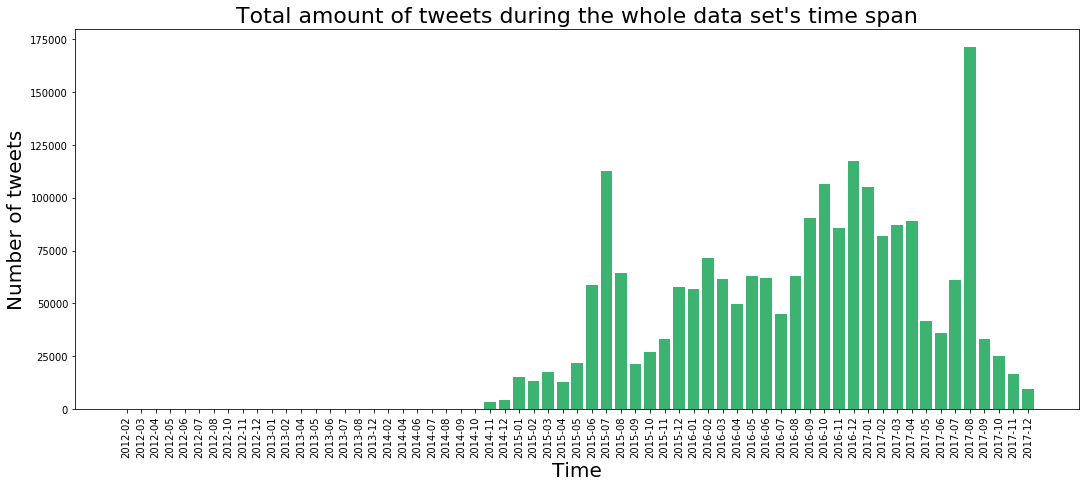

In [219]:
def name_axises(title, xlab, ylab):
    plt.title(title, size=22), plt.xlabel(xlab, size=20), plt.ylabel(ylab, size=20)
# A function for future plotting to save some lines.

data1_timesorted = data1.sort_values("publish_date")
data1_month_days = data1_timesorted["publish_date"].map(lambda x: str(x)[:7])
#if we want only month and days. 
data1_month_count = data1_month_days.value_counts()

fig, ax = plt.subplots(1,1, figsize =(18,7))
over_time_fig = plt.bar(data1_month_count.index, data1_month_count, color = "#3CB371", align="center")
ax.set_xticklabels(data1_month_count.sort_index().index, rotation=90)
name_axises("Total amount of tweets during the whole data set's time span", "Time", "Number of tweets")

The results shows that there were almost no activity until the announcement of the first candidacies in the primaries, with the first visible chart in november 2014. It is difficult to say whether this represents all the russian troll tweets in this period can amount for the same activity, especially when it comes to the final months of the sample. It could still be viewed as a trend, and we look forward to compare this to the second dataset for the final report.


It is interesting to have a look at each month as well. Which period of the year has spanned the most activity?

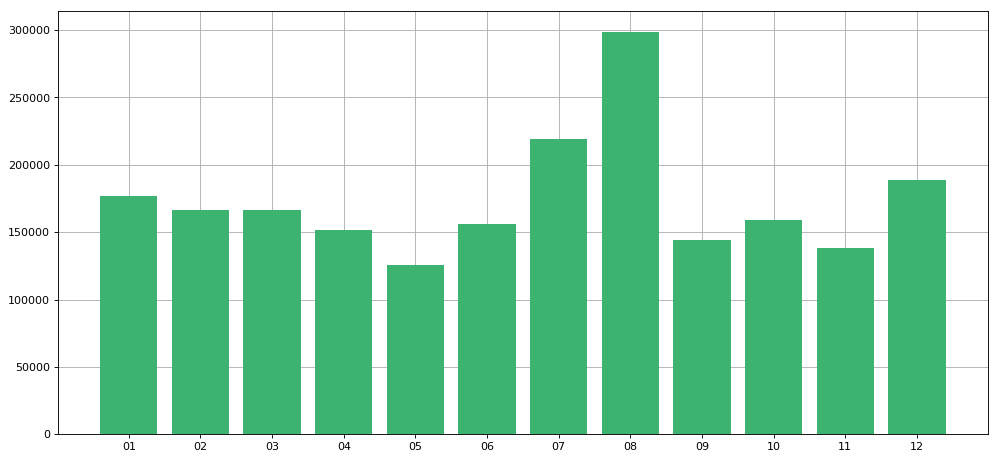

In [220]:
#Sort out the statistics for each month.
data1_months = data1_timesorted["publish_date"].map(lambda x: str(x)[5:7])
data1_only_months = data1_months.value_counts().sort_index()

figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.bar(data1_only_months.index, data1_only_months, color = "#3CB371", align="center", zorder=3)
plt.grid(zorder=0)

We can see that the amount of tweets of each month does not change much except small a small increase in the summer period. This is mostly because of the high summer peak in 2017 as can be viewed on the graph showing the tweets over the total time span of the data set.

What about the spread of tweets throughout a day? May it be possible to detect some irregularities regarding the time differences between Russia and USA? We asked the creators of the dataset who told us that the time stamps are all set in the US time zone. 

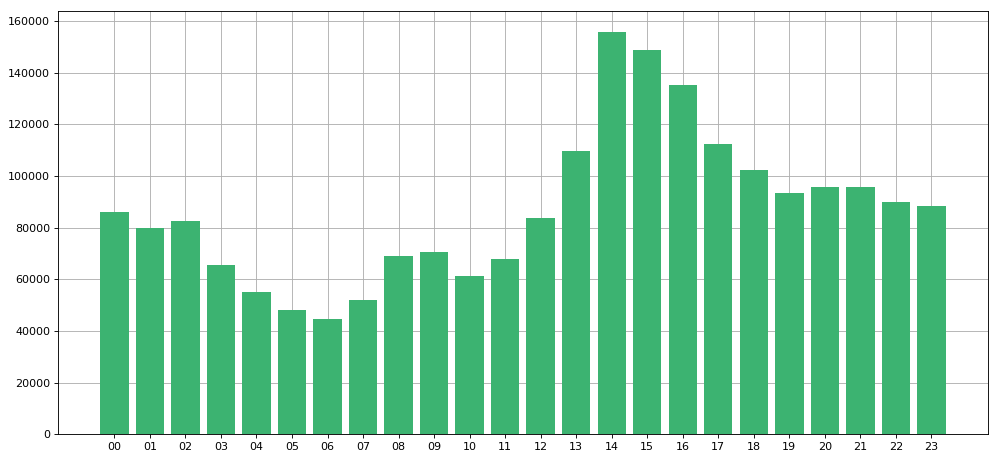

In [221]:
data1_time_of_day = data1_timesorted["publish_date"].map(lambda x: str(x)[11:13])
data1_only_days = data1_time_of_day.value_counts().sort_index()

figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.bar(data1_only_days.index, data1_only_days, color = "#3CB371", align="center", zorder=3)
plt.grid(zorder=0)

Here the russians have done a good job in timing the tweets. The tweets follows an almost perfect frequency regarding to when people are awake, and the majority coming in the evening(here it is necessary to think of the four different time zones in the US). The amount of tweets in the morning may be a bit high, but people would not question this too much if some of the goals are to mimic excessively tweeting political activists or spammers.

### 2.2.x Different user and category stats

We had a look at the users that got a foothold on the app and got the most followers. What kind of category has each user?

,external_author_id,author,account_category,tweet_count,peak_followers
2665808,3.899482e+09,TODAYINSYRIA,NewsFeed,15323,33188
356089,4.301963e+09,BLACKNEWSOUTLET,LeftTroll,2482,40788
2614488,4.508631e+09,THEFOUNDINGSON,RightTroll,8798,42000
2778573,4.332741e+09,USA_GUNSLINGER,RightTroll,3234,43895
2505692,4.355797e+09,SOUTHLONESTAR,RightTroll,3647,53782
684780,4.437234e+09,CRYSTAL1JOHNSON,LeftTroll,8037,56725
935957,4.218156e+09,ELEVEN_GOP,RightTroll,101,59100
2695290,2.752678e+09,TODAYNYCITY,NewsFeed,18478,62088
2092783,4.272871e+09,PAMELA_MOORE13,RightTroll,6197,70734
2599135,4.224730e+09,TEN_GOP,RightTroll,11274,145244


[Text(0,0,'TODAYINSYRIA'),
 Text(0,0,'BLACKNEWSOUTLET'),
 Text(0,0,'THEFOUNDINGSON'),
 Text(0,0,'USA_GUNSLINGER'),
 Text(0,0,'SOUTHLONESTAR'),
 Text(0,0,'CRYSTAL1JOHNSON'),
 Text(0,0,'ELEVEN_GOP'),
 Text(0,0,'TODAYNYCITY'),
 Text(0,0,'PAMELA_MOORE13'),
 Text(0,0,'TEN_GOP')]

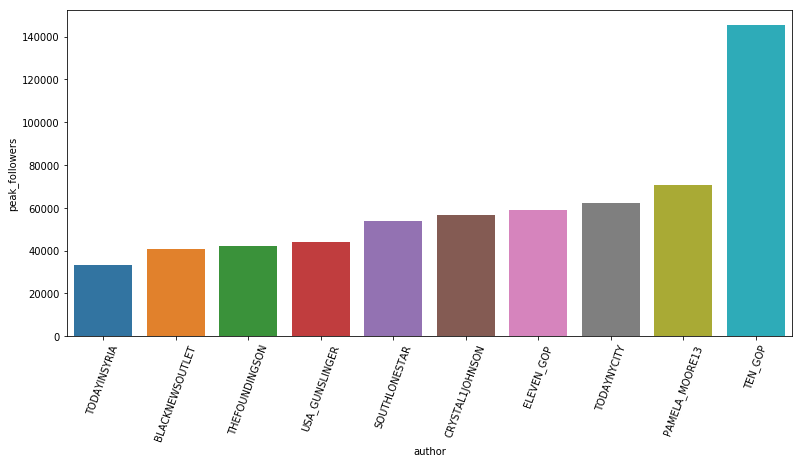

In [222]:
display(most_pop_authors.tail(10))
fig, ax = plt.subplots(1, 1, figsize=(13,6))

sns.barplot(x="author", y="peak_followers", data=most_pop_authors.tail(10))
ax.set_xticklabels(most_pop_authors.tail(10)["author"], rotation=70)


We can see that many of the accounts had a huge amount of followers. In this scale it is fully possible to be viewed as a serious tweeter. The author CRYSTAL1JOHNSON for example is a LeftTroll that was frequently retweeted, for example also by Twitter's own creator, Jack Dorsey (http://uk.businessinsider.com/twitter-ceo-jack-dorsey-retweets-russian-trolls-2018-6?r=US&IR=T). This proves that the trolls can have serious influence on social media. We can also see that many of the top 10 most followed users are RightTroll, which means that this category easily has been passed on as trustworthy

We also want to take a look at the accounts that has tweeted the most. What kind of category has each user?

,external_author_id,author,account_category,tweet_count,peak_followers
740517,2.495568e+09,DAILYSANFRAN,NewsFeed,27962,20306
2325703,2.951506e+09,ROOMOFRUMOR,NewsFeed,28110,12337
1495638,2.587844e+09,KANSASDAILYNEWS,NewsFeed,28746,25871
2443918,2.611151e+09,SEATTLE_POST,NewsFeed,30679,19849
2515125,2.951556e+09,SPECIALAFFAIR,NewsFeed,32253,12023
2713824,2.601236e+09,TODAYPITTSBURGH,NewsFeed,33376,20608
95228,1.679279e+09,AMELIEBALDWIN,RightTroll,34307,2860
2872128,7.890000e+17,WORLDNEWSPOLI,RightTroll,35082,3855
2399272,2.943515e+09,SCREAMYMONKEY,NewsFeed,43685,13295
1008852,3.272641e+09,EXQUOTE,Commercial,53158,858


[Text(0,0,'DAILYSANFRAN'),
 Text(0,0,'ROOMOFRUMOR'),
 Text(0,0,'KANSASDAILYNEWS'),
 Text(0,0,'SEATTLE_POST'),
 Text(0,0,'SPECIALAFFAIR'),
 Text(0,0,'TODAYPITTSBURGH'),
 Text(0,0,'AMELIEBALDWIN'),
 Text(0,0,'WORLDNEWSPOLI'),
 Text(0,0,'SCREAMYMONKEY'),
 Text(0,0,'EXQUOTE')]

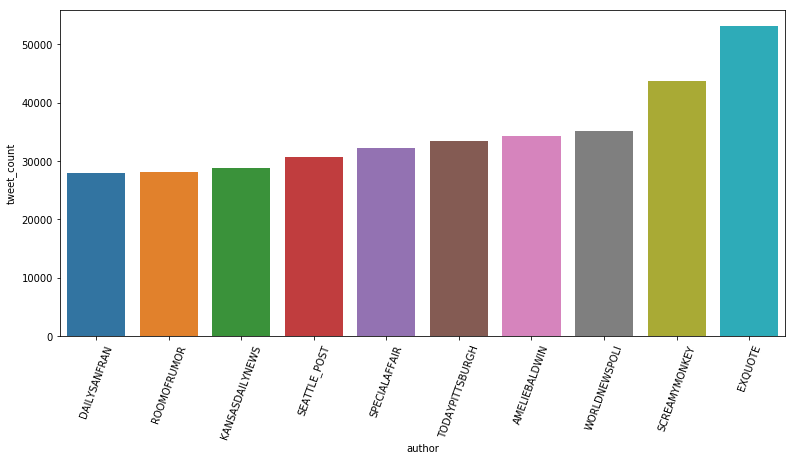

In [223]:
display(most_active_authors.tail(10))
fig, ax = plt.subplots(1, 1, figsize=(13,6))

sns.barplot(x="author", y="tweet_count", data=most_active_authors.tail(10))
ax.set_xticklabels(most_active_authors.tail(10)["author"], rotation=70)


Here we can see that some of the top accounts tweets in enormous scale. Mostly of these are NewsFeed, spreading news disguised as some local institution. This may be to invoke doubt about whether social media news channels can be seen as trustworhty.

# 3) Looking into specific research questions
We found out that many of our initial research questions was harder to answer than initially thought, and that is further descripted in part 4 of this notebook. 

Questions we left out:
- Does the trolls advocate for a common political stance in each specific country? If so which leaning do they have? If not, how polarized are the tweets between left leaning and right leaning?

Questions moved to the next milestone (reasons mentioned in part 4): 
- Is there a way for people without a technical background to determine if a tweet is coming from a Russian troll?
- Which themes does the propaganda mainly revolve around? About which issues should people be particularly careful not to believe everything they read? 

Questions answered:
 
- Were the trolls united with a common political leaning in the period after the primaries in the US elections?
 
- Was the original mission of the Russian trolls for the US election to make sure that Clinton was not elected, or to get Trump elected?
 
- Are the trolls organized as a unit? Do they interact with each other (retweets, etc)?

New questions:

- How does the regions influence the different types of meddling?
  - We wanted to have a look at how the different political leanings were in the different regions. Is there any sort of tactic to each place? Mind looking at how the regions are classified in part 1.1.





### 3.1 How does the regions influence the different types of meddling?

We wish to find how the political leanings of the trolls changed by region of operation. We emphasize that our political labels only take english tweets into account. If not there would likely be several extra countries represented.

In [224]:
#We count our tweets by with account type as column, and countries as rows
categories_country=pd.DataFrame(data1_political.groupby(["region","account_category"]).size()).unstack(level=-1)
categories_country.columns = categories_country.columns.droplevel()
#We add an extra row with the total amount of each account type
#reorder rows
categories_country=categories_country.filter(['RightTroll','LeftTroll',"NewsFeed"], axis=1)
#an extra column is added to sort out countries with to few political tweets
categories_country['Total'] = categories_country.sum(axis=1)
categories_country = categories_country[categories_country["Total"]>400]
categories_country.loc['Total']= categories_country.sum()
display(categories_country)



account_category,RightTroll,LeftTroll,NewsFeed,Total
region,,,,
Canada,333.0,267.0,NaN,600.0
United Kingdom,80.0,NaN,14499.0,14579.0
United States,487210.0,402076.0,573028.0,1462314.0
Unknown,208475.0,6248.0,8129.0,222852.0
Total,696098.0,408591.0,595656.0,1700345.0


We see from our dataframe that the US account for an enormous majority of the political tweets. We also see that there are a lot of political tweets with unknown origin. These two rows nearly account for the entire political dataset, while tweets originating from Canada and UK account for less then 1% combined. 

In order to take a closer look at the leaning of each region we plot the distribution as a stacked bar chart.

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

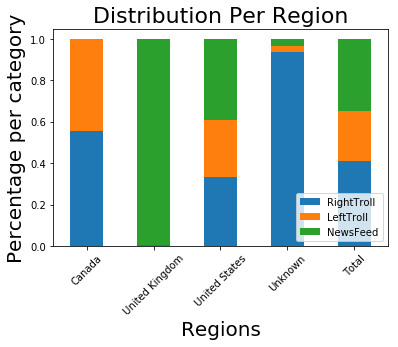

In [225]:
categories_country_distribution = categories_country.loc[:,"RightTroll":"NewsFeed"].div(categories_country["Total"], axis=0)
categories_country_distribution.plot.bar(stacked=True)
name_axises("Distribution Per Region","Regions","Percentage per category")
plt.legend(loc=4)
plt.xticks(rotation=45)

We see that the distribution of the tweets clearly differ from country to country. An example of this is that none of the Canadian tweets are about news, while nearly all of those of the UK are labeled as NewsFeed. We find this very interesting, as most of the newsfeed articles link to pro-Russia articles, which could shape public opinion on countries foreign policies towards Russia. For this reason we would expect some tweets of this kind to be directed towards Canadians. We also would expect more left/right leaning trolls to tweet in the UK in order to take advantage of the political instability leading towards, and in the aftermath of, the Brexit referendum. Furthermore we see that tweets from the USA are way more evenly spread out among the categories than the other represented countries, although it is clear that the majority of tweets are labeled as "NewsFeed" and that the right leaning trolls outnumber the left trolls. Strangely nearly all of the tweets with an unknown origin are right leaning trolls. We find it strange that these tweets do not follow a distribution similar to the overall distribution of the entire set. A reason could be that these accounts find it particularly important not to be geolocated and have taken measures for this. We hope to look further into this.

In [226]:
cols = ["in_reply_to_userid","tweetid"]
replies = new_stats[cols].dropna()
users = new_user["userid"].dropna().to_frame()
retweets_within = pd.merge(users,replies,how="inner",left_on="userid",right_on="in_reply_to_userid")


In [227]:
retweets_within = pd.merge(retweets_within,data2,how="inner",left_on="tweetid",right_on="tweetid")
#This causes a drop from 190000 retweets to 28606, nearly all communication is non english
len(retweets_within)

NameError: name 'data2' is not defined

### 3.2 Did the troll activity change in regards to the american primaries?

This was one of our inital research questions. How did the activity change throughout timeline of the political landscape in the US. We are going to look at two different time periods: Before Clinton and Trump was elected as each of the two parties candidates, and after.

**Before primaries:**

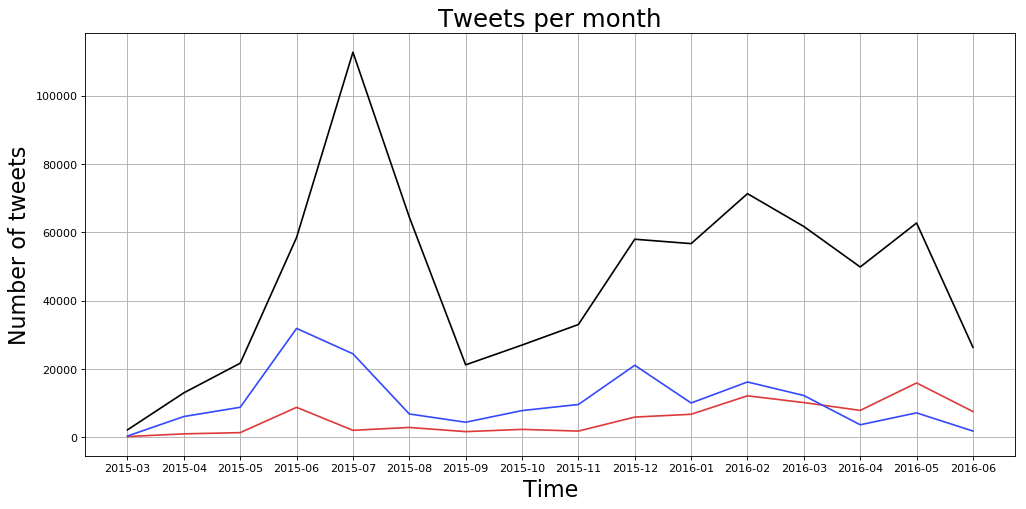

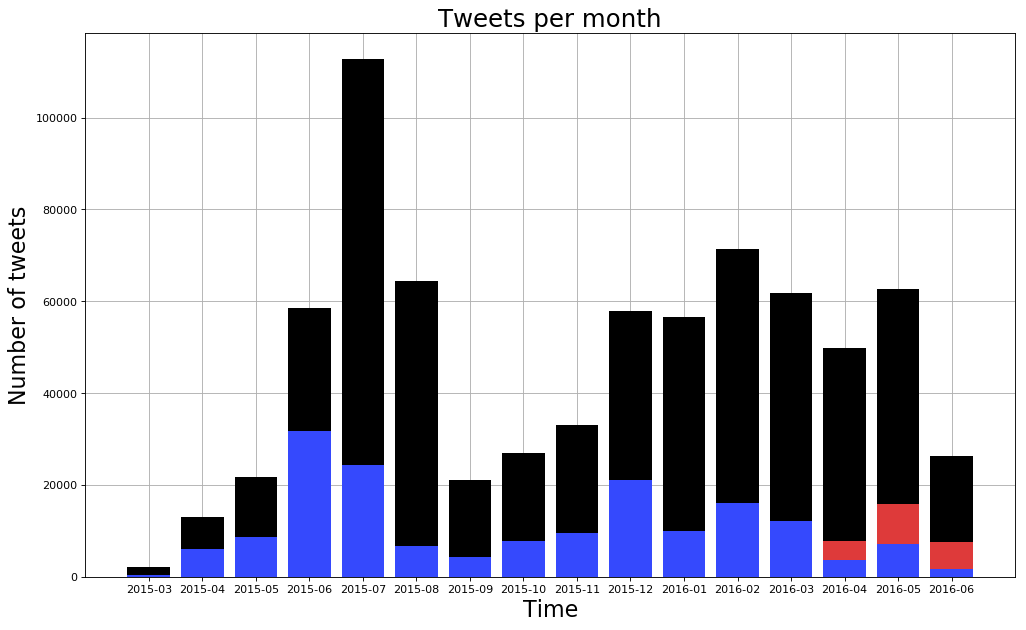

In [228]:
figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(before_primaries_time1.sort_index(), color = "#000000", zorder=3)
plt.plot(bp_left_count1.sort_index(), color = "#DE3A3A",zorder=3)
plt.plot(bp_right_count1.sort_index(), color = "#3549FD",zorder=3)
plt.grid(zorder=0)
name_axises("Tweets per month", "Time", "Number of tweets")

figure(num=None, figsize=(15, 9), dpi=80, facecolor='w', edgecolor='k')
plt.bar(before_primaries_time1.index, before_primaries_time1, color = "#000000", zorder=3)
plt.bar(bp_left_count1.index, bp_left_count1, color = "#DE3A3A", zorder=3)
plt.bar(bp_right_count1.index, bp_right_count1, color = "#3549FD", zorder=3)
plt.grid(zorder=0)
name_axises("Tweets per month", "Time", "Number of tweets")

Things really started when the first people startet announcing their candidacy. In the beginning, after the first announced candidacy, it is almost an exponential growth of tweets. We can also see that it is a lot of tweets that are not political categorized as well. Let's have a quick look at what happened in the month Hillary announced her candidacy.

In [229]:
hillary_month1 = data1.loc[data1["publish_date"] > "2015-04"]
hillary_month1 = hillary_month1.loc[hillary_month1["publish_date"] < "2015-05"]
hm_count1 = hillary_month1["publish_date"].map(lambda x: str(x)[8:10]).value_counts()
#left
hm_left1 = hillary_month1.loc[hillary_month1["account_type"] == "left"]
hm_left_count1 = hm_left1["publish_date"].map(lambda x: str(x)[8:10]).value_counts()
#right
hm_right1 = hillary_month1.loc[hillary_month1["account_type"] == "right"]
hm_right_count1 = hm_right1["publish_date"].map(lambda x: str(x)[8:10]).value_counts()

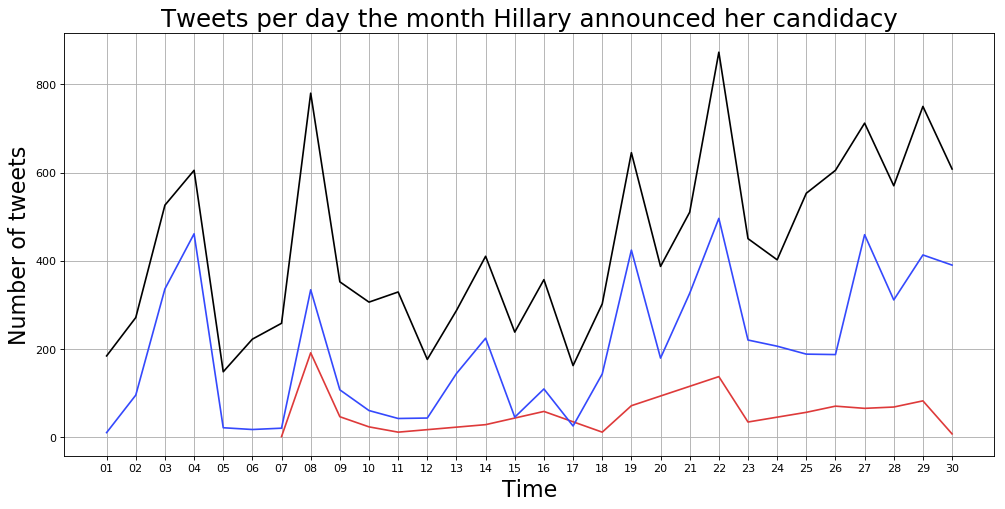

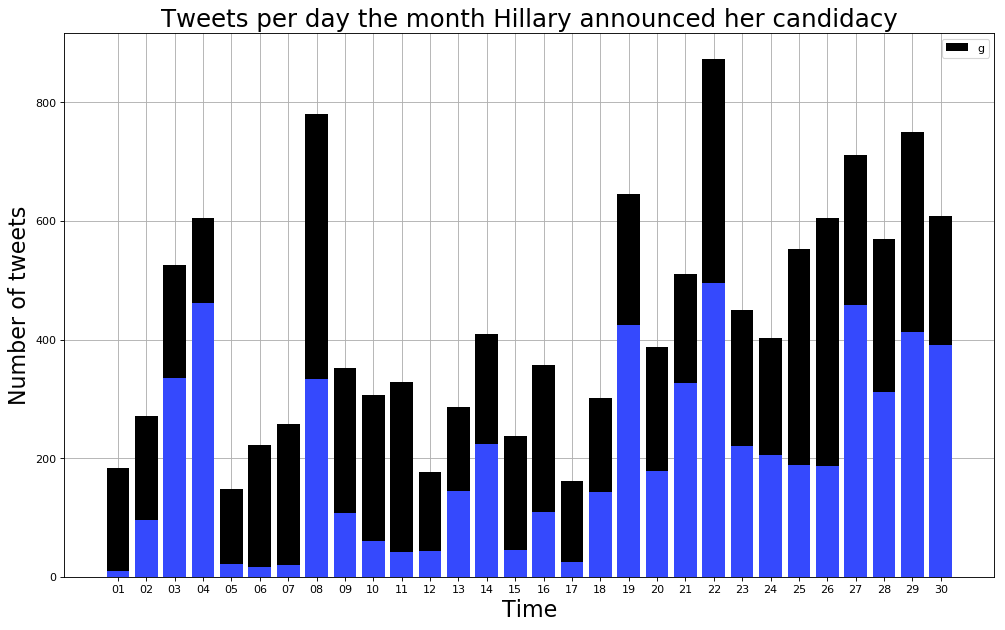

In [230]:
figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(hm_count1.sort_index(), color = "#000000", label = "Total tweets", zorder=3)
plt.plot(hm_left_count1.sort_index(), color = "#DE3A3A",zorder=3)
plt.plot(hm_right_count1.sort_index(), color = "#3549FD",zorder=3)
plt.grid(zorder=0)
name_axises("Tweets per day the month Hillary announced her candidacy", "Time", "Number of tweets")

figure(num=None, figsize=(15, 9), dpi=80, facecolor='w', edgecolor='k')
plt.bar(hm_count1.index, hm_count1, color = "#000000", zorder=3)
plt.bar(hm_left_count1.index, hm_left_count1, color = "#DE3A3A",zorder=3)
plt.bar(hm_right_count1.index, hm_right_count1, color = "#3549FD",zorder=3)
plt.legend(["j"])
plt.legend(["g"])
plt.grid(zorder=0)
name_axises("Tweets per day the month Hillary announced her candidacy", "Time", "Number of tweets")

We can see that the amount of tweets still are in a small scale compared to future results. Hillary's announcement in itself did not spark significant amount of tweets, but we can see that the number of tweets with a right leaning slowly increased as the primaries started to establish itself in the news.

**After primaries**

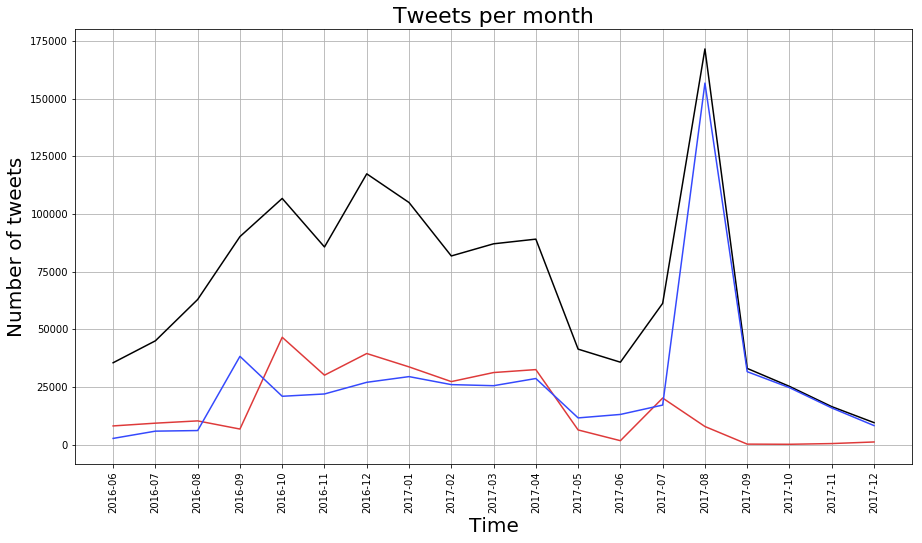

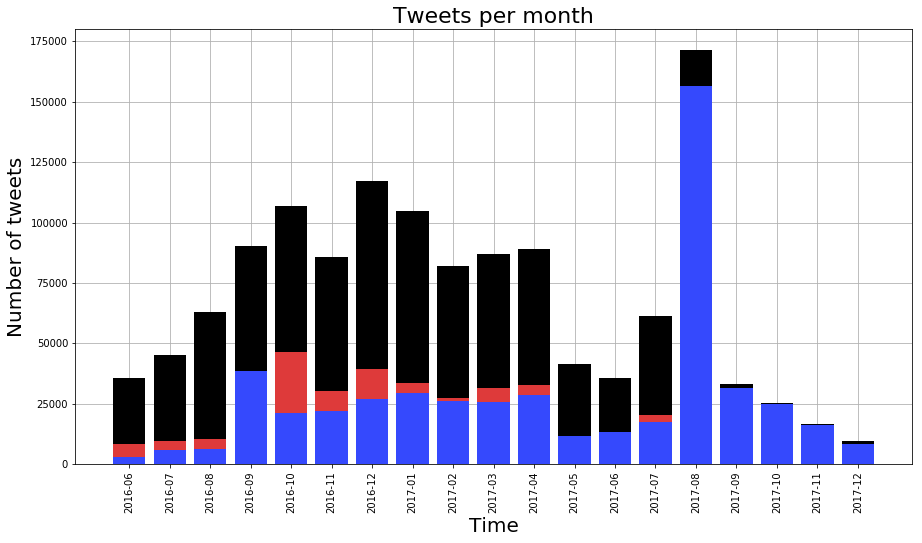

In [231]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
plt.plot(after_primaries_time1.sort_index(), color = "#000000",zorder=3)
plt.plot(ap_left_count1.sort_index(), color = "#DE3A3A",zorder=3)
plt.plot(ap_right_count1.sort_index(), color = "#3549FD",zorder=3)
plt.grid(zorder=0)
ax.set_xticklabels(after_primaries_time1.sort_index().index, rotation=90)
name_axises("Tweets per month", "Time", "Number of tweets")

fig1, ax1 = plt.subplots(1,1, figsize=(15,8))
plt.bar(after_primaries_time1.index, after_primaries_time1, color = "#000000", zorder=3)
plt.bar(ap_left_count1.index, ap_left_count1, color = "#DE3A3A", zorder =3)
plt.bar(ap_right_count1.index, ap_right_count1, color = "#3549FD", zorder =3)
plt.grid(zorder=0)
ax1.set_xticklabels(after_primaries_time1.sort_index().index, rotation=90)
name_axises("Tweets per month", "Time", "Number of tweets")

Regarding to our research question we can say that the primaries actually started the whole thing. At this point, the IRA decided to turn their heads towards american politics. Interestingly enough, we can see that leftist tweets actually dominated until May 2017, and after that it has almost only been the activity of right trolls. Before the primaries the right tweeters were the dominating ones. 


### 3.3 Were they making sure Trump won, or making sure Hillary Lost?

In [232]:
#only regard data before election
political_before_election = data1_political[data1_political["publish_date"]<"2016-11-09"]
#we try to filter out tweets talking about both candidates
clinton_data = political_before_election[political_before_election['content'].str
                            .contains("hillary|clinton|democrat|emails|benghazi|crooked|lock",na=False,case=False)]
trump_data = political_before_election[political_before_election['content'].str
                          .contains("trump|maga| donald |pence|draintheswamp|republican",na=False,case=False)]
#add extra column and make new dataframe
trump_data["candidate"]="Trump"
clinton_data["candidate"]="Clinton"
candidate_data = trump_data.append(clinton_data)

**Now that we have an array of tweets mentioning candidate themed words we display the count of each of them in a bar chart**

(array([0, 1]), <a list of 2 Text xticklabel objects>)

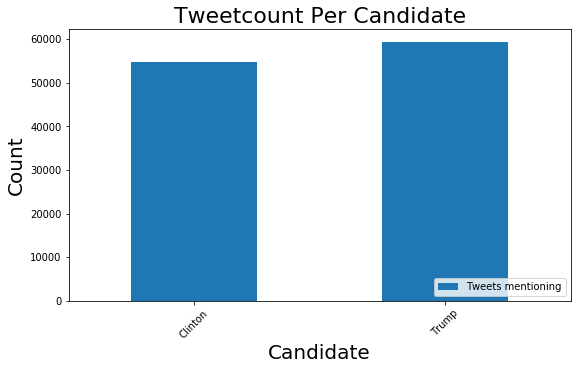

In [233]:
candidate_grouped = candidate_data.groupby("candidate").size().to_frame()
candidate_grouped.columns =["Tweets mentioning"]
candidate_grouped.plot.bar(figsize=(9,5))
name_axises("Tweetcount Per Candidate","Candidate","Count")
plt.legend(loc=4)
plt.xticks(rotation=45)

We see that both candidates are mentioned a lot. Although there is a slight majority of tweets mentioning trump. This does not say much about the preference towards either of the candidates. It does however, imply that both candidate were a major focus of the Russian trolling activity.

To get a better sense of the trolls opinions on the candidates, we group by the tweets mentioning each candidate by the account categories. We assume that left trolls have a negative view of Donald Trump, and Right Trolls have a negative view of Hillary Clinton. It could be the case that LeftTrolls have a favorable view of Clinton, although these tweets mentioning her might be to favor other democratic candidates. The same goes for Donald Trump. In order to minimize this uncertainty we only visualize data between the main election and the primaries. We assume the NewsFeed tweets mentioning the candidates have a leaning, but as we cannot say for sure. We disregard these. 

(array([0, 1]), <a list of 2 Text xticklabel objects>)

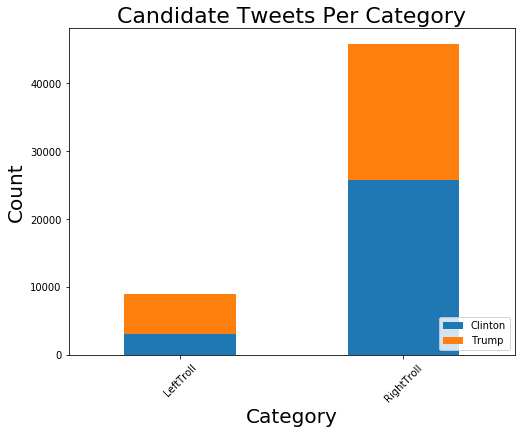

In [234]:
#Filter away tweets befor the primaries
candidate_between = candidate_data[candidate_data["publish_date"]>"2016-6-14"]
#Group by account category and put the candidate mentioned as columns
mentions_per_category = candidate_between.groupby(["account_category","candidate"]).size().to_frame().unstack(level=-1)
mentions_per_category.columns = mentions_per_category.columns.droplevel()
#We drop tweets about newsarticles
mentions_per_category.drop("NewsFeed", inplace=True)
mentions_per_category.plot.bar(stacked=True, figsize =(8,6))
name_axises("Candidate Tweets Per Category","Category","Count")
plt.legend(loc=4)
plt.xticks(rotation=45)

We see that a great majority of the Russian tweets are categorized as "RightTroll". This obviously indicate that they wanted a specific outcome. It is however, strange that a not unsignificant amount of tweets in this period is categorized as LeftTroll, as this suggests that tweets sent by the Russian trolls favored Hillary over Trump. From our chart it is also clear that both sides mention both candidates a lot. Strangely, there is a counterintuitive distribution between the candidates for both categories. We see that a majority of left leaning tweets are mentioning Trump, while the right leaning tweets mostly relate to Hillary. This Indicates that it is easier to spread hate and distrust towards a candidate than trust and love. This could also explain why there are left leaning trolls mentioning Trump, as this could be means to help stir up anger among the american population, and destabilize the political climate in the country.

We are also curious of how many tweets in the dataset mention each candidate as this could give us a sense of to which degree both candidates were part of the agenda for the trolls on either side of the political spectrum. In this case we look at all tweets before the election. To take a look at the agenda overall.

(array([0, 1]), <a list of 2 Text xticklabel objects>)

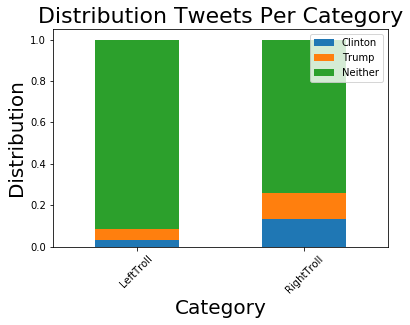

In [235]:
#Get tweets not mentioning either candidate, get number of such tweets per category
non_candidate_tweets = political_before_election[~political_before_election["content"].isin(candidate_data["content"].tolist())]
non_candidate_category = non_candidate_tweets.groupby("account_category").size()
#Get amount of tweets by category and candidate
total_pol =candidate_data.groupby(["account_category","candidate"]).size().to_frame().unstack(level=-1)
total_pol.columns = total_pol.columns.droplevel()
#Add extra column with amount of tweets not mentioning candidates
total_pol["Neither"]=non_candidate_category
#Drop newsfeed
total_pol.drop("NewsFeed", inplace=True)
#plot
total_pol = total_pol.div(total_pol.sum(axis=1), axis=0)
total_pol.plot.bar(stacked=True)
name_axises("Distribution Tweets Per Category","Category","Distribution")
plt.legend(loc=1)
plt.xticks(rotation=45)

We see that there is a way higher focus from the right leaning side on the candidates themselves. While the left have a way higher representation of tweets not mentioning either of the candidates. This could indicate that the left side were mostly focused on spreading political discourse, or maybe focusing on other candidates in order to divide this side. For the right side however, there are a lot more tweets mentioning the candidates. This indicates a lot more oriented strategy towards the actual result of the election than the left side. We find it interesting that such a high proportion of the right leaning tweets do not mention either candidates on the right side, as the goal of the meddling  supposedly was to influence the outcome of the election.

### 3.x Are the trolls interacting with each other?

**In order to answer this question we wish to inspect the content of the tweets to see if the trolls write the same tweets. If this is the case it is very likely that they operate as a unit with specific messages to share.**

,count
content,
NewsOne Now Audio Podcast: Bishop E.W. Jackson Calls #BlackLivesMatter Is Movement “Disgraceful”,85
"So, if someone shoots me he commits a crime, if a cop shoots me he prevents one. Double standarts! #MikeBrown #Fergusonremembers",38
#Hancock Co. #K9 honored by #PETA as hero #dog. #Lucas: That's just what I do� Love it! �� http://t.co/IrhReleo8v http://t.co/zYflkYJke1,33
'@PoliceFirstNow @DrewFlorio @BettinaVLA @GovernorPerry @USATODAY your a troll. To even insinuate something like that is beyond credulity!!',33
#walmart #KochFarms https://t.co/szzqrlBAAy https://t.co/GrTM9etEQ9,33


No handles with labels found to put in legend.


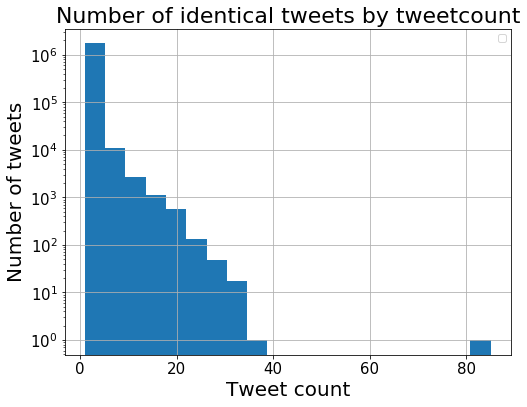

In [236]:
#Remove tweets with exact same content by the same author
without_same_tweet_author = data1.filter(["external_author_id","content","post_type"]).drop_duplicates()
#Count occurences of each tweet content and sort
content_df = without_same_tweet_author.groupby("content").size().to_frame()
content_df.columns=["count"]
content_df = content_df.sort_values("count",ascending=False)
#display findings
display(content_df.head(5))
#plot the tweetcount distribution in a histogram
content_df.hist(bins=20, figsize=(8,6), xlabelsize=15, ylabelsize=15, log =True)
name_axises("Number of identical tweets by tweetcount","Tweet count","Number of tweets")
plt.legend(loc=1)

We see that there are clearly several tweets that have been tweeted several times by several people. However according to the distribution these are in an overwhelming minority compared to tweets only posted a small number of times. This indicates that they are organized to some extent, as they do have a lot of tweets with the same content independent of each other, although this is in only a small extent compared to the overall tweeting.

We are curious to see if these tweets are mainly original tweets, or if the case is that they mainly retweet the same tweets. 

In [237]:
#Count of the same content based with post type on columns
with_post_type = without_same_tweet_author.groupby(["content","post_type"]).size().to_frame().unstack(level=-1)
with_post_type.columns = with_post_type.columns.droplevel()
#sort by common retweet and display, then do same for original tweets
with_post_type = with_post_type.sort_values("RETWEET",ascending=False)
display(with_post_type.head(10))
with_post_type = with_post_type.sort_values("ORIGINAL",ascending=False)
display(with_post_type.head(10))

post_type,ORIGINAL,QUOTE_TWEET,RETWEET
content,,,
"So, if someone shoots me he commits a crime, if a cop shoots me he prevents one. Double standarts! #MikeBrown #Fergusonremembers",1.0,NaN,37.0
#Hancock Co. #K9 honored by #PETA as hero #dog. #Lucas: That's just what I do� Love it! �� http://t.co/IrhReleo8v http://t.co/zYflkYJke1,NaN,NaN,33.0
'@PoliceFirstNow @DrewFlorio @BettinaVLA @GovernorPerry @USATODAY your a troll. To even insinuate something like that is beyond credulity!!',NaN,NaN,33.0
#Obama Claims #ClimateChange Greatest Threat @POTUS ➰ FLOTUS FLY SEPARATE PLANES #JunkScience #TCOT #PJNET�� http://t.co/tKDHRRPUE2,NaN,NaN,32.0
Take a read: http://t.co/ViuSJrjCVu #iacaucus http://t.co/yNPl1D9eeS,NaN,NaN,32.0
"Getting the feeling ""Prince"" Shembo... Should've never been named Prince. Don't let the door hit you on the way out",NaN,NaN,32.0
#walmart #KochFarms https://t.co/szzqrlBAAy https://t.co/GrTM9etEQ9,1.0,NaN,32.0
#climatechange zealots hypothesize about Armageddon scenarios while holding a straight face. #remarkable,NaN,NaN,32.0
MT @ChristiChat: #WakeUpAmerica - FOUR AMERICANS Are Being Held Prisoner In IRAN! http://t.co/Aw29g1CfKn #FreeAmirNow #PJNET,NaN,NaN,31.0


post_type,ORIGINAL,QUOTE_TWEET,RETWEET
content,,,
NewsOne Now Audio Podcast: Bishop E.W. Jackson Calls #BlackLivesMatter Is Movement “Disgraceful”,85.0,NaN,NaN
RT @thehill: Trump repeatedly interrupted by protesters shouting #BlackLivesMatter,31.0,NaN,NaN
Judge Rips Media,29.0,NaN,NaN
RT @RNRIllinois: Remember Kids. Dont do CNN. Its a gateway Station that leads to other Liberal media. #RedNationRising #tcot #PJNET https:/…,26.0,NaN,2.0
RT @jstines3: It's not CLUMPS of TISSUE that move and smile and react! #DefundPP #PPSellsBabyParts #TCOT #CCOT #PJNET https://t.co/1IYLkT…,23.0,NaN,NaN
#BlackLivesMatter,22.0,NaN,8.0
RT @RNRIllinois: In this figure you can see how Socialism works at the Beach. #RedNationRising #tcot #FeelTheBern #UniteBlue #PJNET https:/…,21.0,NaN,NaN
RT @hannahkauthor: Some media are showing(manipulating and controlling) #Election2016 polls to confuse voters? #TGDN #PJNET #TCOT,19.0,NaN,NaN
RT @peddoc63: Closest we have EVER been to Ronald Reagan is @tedcruz,19.0,NaN,NaN


We see from the two sorted frames that most of the tweets that occur many times are retweets. This makes sense as a retweet is by design the same tweet. We also see that the majority of the "original" tweets in the set start with "RT" meaning that the given tweet is actually a retweet. All this indicates that the trolls mainly avoid writing the same things. They do not shy away from retweeting the same things though. We find it interesting that the most common content of the trolls tweets is original tweets containing a quite complicated string that have a low likelyhood of occuring by coincidence. This could indicate that the trolls at times use bots, or that lots of accounts are managed by the same person, that merely copy the same string into the tweet. 

In order to take a look at weether they run bots, we remove the links in the tweets and sort. If the amount of tweets with the same content increase drastically this is an indication that they run bots that re-use the description of the links

In [238]:
#we strip data on https to remove links and only keep start of tweet
stripped_data = without_same_tweet_author
stripped_data["content"]=stripped_data["content"].apply(lambda s: str(s).split("https")[0].strip())
#we sort data by contents of the remaining part of the tweet. We then remove the top entry as this is an empty string.
stripped_data = stripped_data.groupby(["content"]).size().sort_values(ascending=False).to_frame().iloc[1:]
stripped_data.columns=["count"]
#we display the resulting tweets sorted by tweet count
display(stripped_data.head(10))

,count
content,
Targeted #ISIS accounts,960
Listen to the title track of the upcoming mashup album #TheFourHorsemen #TheArtOfWar ft #T…,378
'@WarfareWW,310
I added a video to a @YouTube playlist,268
I liked a @YouTube video,259
�,249
Comment here on,245
Listen to the #Mashup mix #NASDOTCOM feat #NAS and #COMMON &gt;&gt;,239
Just posted a photo,230


We see that there are a lot more tweets with the same content when we remove the containing web links. This indicates heavy bot use by the trolls. In order to compare the difference we plot the distributions of tweetcount side by side, before and after removing links.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


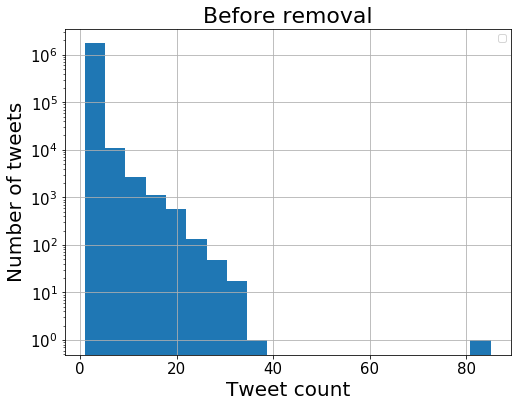

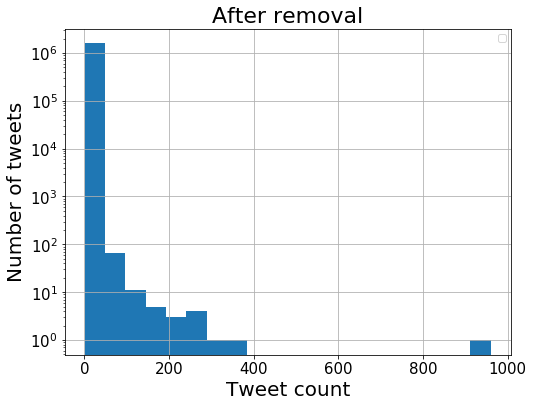

In [239]:
content_df.hist(bins=20, figsize=(8,6), xlabelsize=15, ylabelsize=15, log =True)
name_axises("Before removal","Tweet count","Number of tweets")
plt.legend(loc=1)

stripped_data.hist(bins=20, figsize=(8,6), xlabelsize=15, ylabelsize=15, log =True)
name_axises("After removal","Tweet count","Number of tweets")
plt.legend(loc=1)

We see that the distribution is clearly skewed towards more tweets with the same content. We conclude that the bots are organized to some extent by using bots etc. We do however suspect that they are run by the same people

## Are the trolls retweeting each other ---- spark


We want to see weether the trolls communicate, and if they do: get an idea of how. 
In order to do this, we use the newer dataset as this has info about what tweets, and therefore, which users a tweet is responding to. We start by loading some of the dataframes to parquet and then read.

In [166]:
#data2.to_parquet('data2.parquet.gzip', compression='gzip')
#new_stats.to_parquet('stats.parquet.gzip', compression='gzip')
#new_tweets.to_parquet('tweets.parquet.gzip', compression='gzip')
#new_text.to_parquet('text.parquet.gzip', compression='gzip')
new_user.to_parquet('user.parquet.gzip', compression='gzip')


In [167]:
#tweets = spark.read.parquet('tweets.parquet.gzip')
text = spark.read.parquet('text.parquet.gzip')
stats = spark.read.parquet('stats.parquet.gzip')
users = spark.read.parquet('user.parquet.gzip')


**We start by counting the total number of tweets, as well as how many english tweets the dataset contains**

In [168]:
print("Total Tweets:",text.count())
print("Total English Tweets:",text.filter("tweet_language = 'en'").count())

Total Tweets: 9041308
Total English Tweets: 3261931


In [169]:
s = stats.filter("userid == '2d5c740d091be162a2085e2981ed0d2765e07aca9743fd83a43023ff450cb360'").select(col("tweetid").alias("t"))
s = stats.join(s, stats.quoted_tweet_tweetid == s.t,"inner").select("in_reply_to_tweetid","quoted_tweet_tweetid",
                                                                   "retweet_tweetid")
s.show()

+-------------------+--------------------+---------------+
|in_reply_to_tweetid|quoted_tweet_tweetid|retweet_tweetid|
+-------------------+--------------------+---------------+
|               null|6.695593267852779...|           null|
|               null|6.695593267852779...|           null|
|               null|6.695593267852779...|           null|
|               null|6.695593267852779...|           null|
|               null|6.695593267852779...|           null|
|               null|6.695593267852779...|           null|
|               null|6.695593267852779...|           null|
|               null|6.695593267852779...|           null|
|               null|6.695593267852779...|           null|
|               null|6.695593267852779...|           null|
|               null|6.695593267852779...|           null|
|               null|6.695593267852779...|           null|
|               null|6.695593267852779...|           null|
|               null|6.695593267852779...|           nul

**In order to get a sense of the extent of the communication we want to get a sense of the overall activity of the user, and therefore make a dataframe containing information of how many tweets a user has made, as well as how many times their tweets have been retweeted, replied to or quoted by other users. We also add the language of the user.**

**We will continue adding columns in order to get a complete sense of how the communication is conducted**

In [170]:
n_stats = stats.select("userid","reply_count","quote_count","retweet_count","tweetid")
summed = n_stats.groupBy("userid").agg(count("tweetid"), sum("reply_count"),sum("quote_count"),sum("retweet_count"))
summed = summed.join(users, "userid").select("userid",col("account_language").alias("language"),"count(tweetid)",
                                             "sum(retweet_count)", "sum(reply_count)","sum(quote_count)")
summed.sort(desc("sum(retweet_count)")).show(5)

+------------------+--------+--------------+------------------+----------------+----------------+
|            userid|language|count(tweetid)|sum(retweet_count)|sum(reply_count)|sum(quote_count)|
+------------------+--------+--------------+------------------+----------------+----------------+
|        4224729994|      en|         10794|           6000296|          632061|          520919|
|        4437233895|      en|          7915|           3776481|           77201|          273749|
|        4272870988|      en|          6203|           2223854|          244440|          207688|
|842368501528559616|      en|          2288|           1217081|          115617|           53697|
|905514350684844036|      en|          3067|           1171652|           27778|           94465|
+------------------+--------+--------------+------------------+----------------+----------------+
only showing top 5 rows



**We continue by adding columns for how many times a user has retweeted someone, this could be any twitter user. We also add a column stating how many times a individual twitter user has been retweeted by the trolls.**

In [183]:
#make dataframe with retweets, containing userful information
retweets = (stats.where(col("retweet_tweetid").isNotNull())).select("retweet_tweetid","retweet_userid","userid",
                                                                    col("tweetid").alias("retweeting_tweetid"))

#Find how many times a user has retweeted and add this to our user-dataframe
retweets_by_user = retweets.groupBy("userid").agg(count("*"))\
                .select(col("userid").alias("usrid"),col("count(1)").alias("retweets"))
aggregated_with_retweets = summed.join(retweets_by_user,retweets_by_user.usrid == summed.userid,"left_outer").drop("usrid")


#Make dataframe of tweets where trolls retweets other trolls
u=users.select(col("userid").alias("usrid"))
retweets_within = users.select("userid").join(retweets, "userid")
retweets_within = u.join(retweets_within, retweets_within.retweet_userid==u.usrid )\
                .select("retweet_tweetid","retweeting_tweetid","retweet_userid","userid")
    
#Make df containing number of times a user has been retweeted by trolls, and add column to user-df
retweeted_by_troll = retweets_within.groupBy("retweet_userid").agg(count("*"))\
                .select("retweet_userid",col("count(1)").alias("retweeted_by_trolls"))
aggregated_with_retweets = aggregated_with_retweets.join(retweeted_by_troll,retweeted_by_troll.retweet_userid 
                                            == aggregated_with_retweets.userid,"left_outer").drop("retweet_userid")

#Make df containing number of times a troll has retweeted other trolls, and add column to user-df
retweets_of_troll = retweets_within.groupBy("userid").agg(count("*"))\
                .select("userid",col("count(1)").alias("retweets_of_troll"))
aggregated_with_retweets = aggregated_with_retweets.join(retweets_of_troll,"userid","left_outer")


**We now wish to add similar columns to see how the trolls speak to each other in the litteral sense; by replying to each other. We first add total number of replies by user, then add how many times they have been replied to, as well as how many times they themselves have replied to other trolls.**

In [191]:
#filter out everything that is not replies
replies = stats.where(col("in_reply_to_tweetid").isNotNull())\
        .select("in_reply_to_tweetid","in_reply_to_userid","userid",col("tweetid").alias("replyid"))

    
#make df with number of times each user has replied to someone, not only trolls, add this to main df.
replies_by_user = replies.groupBy("userid").agg(count("*"))\
                .select("userid",col("count(1)").alias("number_of_replies"))
aggregated_with_replies = aggregated_with_retweets.join(
                replies_by_user,"userid","left_outer")

#replies from one troll to another
replies_within = u.join(replies, u.usrid == replies.in_reply_to_userid)
replies_within = replies_within.join(users,"userid").select("userid","in_reply_to_userid","replyid")
    
#add a column with how many times each user have been replied to by a troll
replies_to_user = replies_within.groupBy("in_reply_to_userid").agg(count("*"))\
                .select(col("in_reply_to_userid").alias("userid"),col("count(1)").alias("replies_by_trolls"))
aggregated_with_replies = aggregated_with_replies.join(replies_to_user,"userid","left_outer")


#make column with count of times a troll has retweeted another troll
replies_by_user = replies_within.groupBy("userid").agg(count("*"))\
                .select("userid",col("count(1)").alias("replies_to_trolls"))
aggregated_with_replies = aggregated_with_replies.join(replies_by_user,"userid","left_outer")


**Now that we have information of how they retweet and reply to each other we additionally want to add information on how the trolls interact using quote tweets. In the same matter as before, we add how many times each troll have quoted someone else, how many times they quoted another troll, as well as how many times they have been quoted by other trolls.**

In [244]:
#Filter out everything that is not quotes
quotes = stats.where(col("quoted_tweet_tweetid").isNotNull())\
        .select("quoted_tweet_tweetid",col("userid").alias("quoting_userid"),col("tweetid").alias("quoteid"))

#Add column to main dataframe with how many times a troll has quoted someone
quotes_by_user = quotes.groupBy("quoting_userid").agg(count("*"))\
                .select("quoting_userid",col("count(1)").alias("quote_tweets"))
aggregated_with_quotes = aggregated_with_replies.join(quotes_by_user,quotes_by_user.quoting_userid 
                                        == aggregated_with_replies.userid,"left_outer").drop("quoting_userid")

#Creating df where troll quotes other trolls
quotes_within = stats.drop("quoted_tweet_tweetid").join(quotes, stats.tweetid == quotes.quoted_tweet_tweetid)\
                .select("quoting_userid","quoted_tweet_tweetid","quoteid",col("userid").alias("quoted_userid"))

#Add column to main dataframe with how many times a troll has been quoted by another troll
quotes_to_user = quotes_within.groupBy("quoted_userid").agg(count("*"))\
                .select("quoted_userid",col("count(1)").alias("quoted_by_trolls"))
aggregated_with_quotes = aggregated_with_quotes.join(quotes_to_user,quotes_to_user.quoted_userid 
                                                     == aggregated_with_quotes.userid,"left_outer")\
                                                    .drop("quoted_userid")

    
#Add column showing how many times each troll has quoted another troll
quotes_by_user = quotes_within.groupBy("quoting_userid").agg(count("*"))\
                .select("quoting_userid",col("count(1)").alias("quoted_a_troll"))
aggregated_with_quotes = aggregated_with_quotes.join(quotes_by_user,quotes_by_user.quoting_userid == 
                                                     aggregated_with_quotes.userid,"left_outer").drop("quoting_userid")


In [245]:
user_interactions = aggregated_with_quotes.na.fill(0)


In [246]:
interactions_df = user_interactions.toPandas().set_index("userid")
interactions_df.head(5)

,language,count(tweetid),sum(retweet_count),sum(reply_count),sum(quote_count),retweets,retweeted_by_trolls,retweets_of_troll,number_of_replies,replies_by_trolls,replies_to_trolls,quote_tweets,quoted_by_trolls,quoted_a_troll
userid,,,,,,,,,,,,,,
1cf2f6f6e0e87b7856deda07f1f4ba15dba59fe610283cb1379c1c4c97a00e3a,en,10,0,0,0,0,0,0,0,0,0,0,0,0
202c8708b3ed415e943eade0a8e5bfb0ce7ceaf93fcc462d3bb271f73e487f2b,ru,9292,764,7,0,6111,678,3226,53,2,52,0,0,0
36f2768e6fcac2041cd5604315cab62bc02c808f1ddb3492bb7b265db4875a59,en,3932,256,62,17,2263,53,322,18,1,0,44,1,3
3daea00c3d9d2530c840254c6fa6fc3c14837681269a8739a23f463b844e1c16,ru,1865,51,89,3,80,0,0,228,0,0,3,0,0
4a899897e0eeacbb0df34904b6fa75a5560c1b305051f4b86ae6652bae2738ca,en,10,0,0,0,10,0,0,0,0,0,0,0,0


In [247]:
interactions_df.groupby("language").sum()

,count(tweetid),sum(retweet_count),sum(reply_count),sum(quote_count),retweets,retweeted_by_trolls,retweets_of_troll,number_of_replies,replies_by_trolls,replies_to_trolls,quote_tweets,quoted_by_trolls,quoted_a_troll
language,,,,,,,,,,,,,
ar,3452,344,193,0,590,2,65,1617,8,3,162,1,0
de,102657,70081,15051,8736,12550,1316,1271,2035,359,359,1144,54,54
en,4608003,23066172,1773081,1667743,1711236,368552,305737,133147,17323,19525,157600,14064,13962
en-gb,21494,68453,3575,1561,1849,8016,599,23,456,2,1,3,0
es,285044,103021,15310,9207,860,263,256,1,0,0,10702,34,114
fr,1409,72,21,1,265,0,0,46,0,0,39,0,0
id,22966,155,68,6,0,0,0,0,0,0,1,0,0
it,13105,0,4,0,13098,0,0,0,0,0,106,0,0
ru,3953675,7940616,730729,104105,1592734,522156,592377,129339,26370,24627,18112,685,711


### Total user interactions

In [258]:
interactions_df["Total_reactions_from_trolls"] = interactions_df["retweeted_by_trolls"]+interactions_df["replies_by_trolls"]+interactions_df["quoted_by_trolls"]
interactions_df["Total_reactions_to_trolls"] = interactions_df["retweets_of_troll"]+interactions_df["replies_to_trolls"]+interactions_df["quoted_a_troll"]
interactions_df["Total_interactions"]=interactions_df["retweets"]+interactions_df["number_of_replies"]+interactions_df["quote_tweets"]
interactions_df["Total_times_interacted_with"]=(interactions_df["sum(retweet_count)"]+interactions_df["sum(reply_count)"]+interactions_df["sum(quote_count)"])
interactions_df["Ratio_reactions_to_trolls"] = interactions_df["Total_reactions_to_trolls"]/interactions_df["count(tweetid)"]
interactions_df["Ratio_reactions_from_trolls"] = interactions_df["Total_reactions_from_trolls"]/interactions_df["Total_times_interacted_with"]
interactions_df["Ratio_interaction_with_trolls"] = interactions_df["Total_reactions_to_trolls"]/interactions_df["Total_interactions"]
interactions_df = interactions_df.sort_values("Ratio_interaction_with_trolls",ascending=False)

interactions_df.head(10)

,language,count(tweetid),sum(retweet_count),sum(reply_count),sum(quote_count),retweets,retweeted_by_trolls,retweets_of_troll,number_of_replies,replies_by_trolls,...,quote_tweets,quoted_by_trolls,quoted_a_troll,Total_reactions_from_trolls,Total_reactions_to_trolls,Total_interactions,Ratio_reactions_to_trolls,Ratio_reactions_from_trolls,Ratio_interaction_with_trolls,Total_times_interacted_with
userid,,,,,,,,,,,,,,,,,,,,,
9517e09eeb67a37282972f2cf008232a12a599ce5668a1c576aeea2595218d4b,en,304,0,1,0,1,0,1,0,0,...,0,0,0,0,1,1,0.003289,0.000000,1.0,1
526d7c6abedfc1625aa8ef179fbcd4872ea763282668c49a17877a1cba6cbaed,en,3,0,0,0,1,0,1,0,0,...,0,0,0,0,1,1,0.333333,NaN,1.0,0
0e082da92a7b3629b1d1cd21c31f3277acf9858b7842453810a7809d6a1bf3b5,en,336,12,1,0,13,10,13,0,0,...,0,0,0,10,13,13,0.038690,0.769231,1.0,13
cc9546eafdad2af45c426b859827f5a136b6898b6fb1cfb0f5016475118960af,en,311,1,3,0,0,0,0,1,0,...,0,0,0,0,1,1,0.003215,0.000000,1.0,4
f27e9b75f38255b7e233f60a453e2d9816691de122b4275038e9347c3b7d9ddb,en,379,7,0,0,4,0,4,13,0,...,1,0,1,0,18,18,0.047493,0.000000,1.0,7
08bf215f69bdb9cb308d0266dffcd1af6bc54d214cb92fd3f740112fff23f3a9,en,430,1,2,1,1,1,1,1,0,...,0,0,0,1,2,2,0.004651,0.250000,1.0,4
9e95a4994850488485a608f87f3c4273de4b83ff58407cc9ac30ca655bca57d6,de,2,0,0,0,2,0,2,0,0,...,0,0,0,0,2,2,1.000000,NaN,1.0,0
364da4075e68fbf56ea75bf98cc92ab620aef676a6ace7c49d91e81236522bea,en,298,1,2,0,2,0,2,0,0,...,0,0,0,0,2,2,0.006711,0.000000,1.0,3
83b2b745604282d8d1415d67767762a52c148b06dc1fc2fad20d0394992c19bf,en,421,1,2,0,0,0,0,6,1,...,0,0,0,1,6,6,0.014252,0.333333,1.0,3


## visualisation

**tweet count histogram**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b110e2940>]],
      dtype=object)

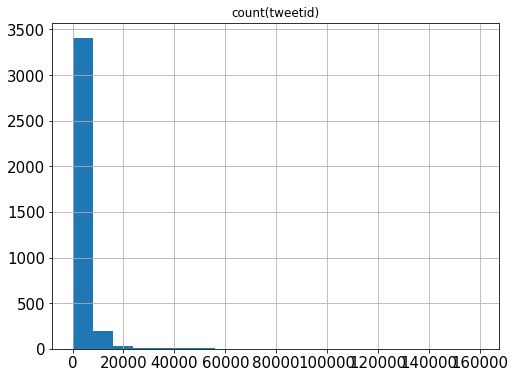

In [242]:
interactions_df[["count(tweetid)"]].hist(bins=20, figsize=(8,6), xlabelsize=15, ylabelsize=15, log =False)


**Total user interactions hist**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b1059a9b0>]],
      dtype=object)

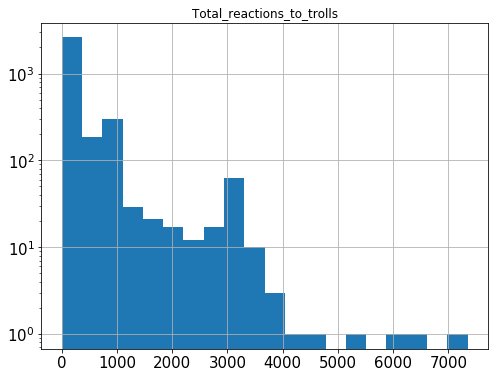

In [251]:
enough_tweets = interactions_df[interactions_df["count(tweetid)"]>10]
enough_tweets[["Total_reactions_to_trolls"]].hist(bins=20, figsize=(8,6), xlabelsize=15, ylabelsize=15, log =True)


**We see that most trolls rarely interact with users, although some of them react a whole lot to them**

### Top interacting users

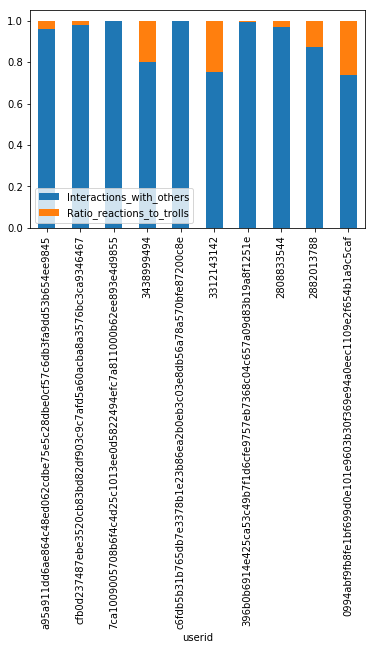

In [257]:
most_interacting = interactions_df.sort_values("Total_interactions",ascending=False).head(10)
most_interacting["Interactions_with_others"]= 1-most_interacting["Ratio_reactions_to_trolls"]
most_interacting[["Interactions_with_others","Ratio_reactions_to_trolls"]].plot.bar(stacked=True)


### Top interacted with users

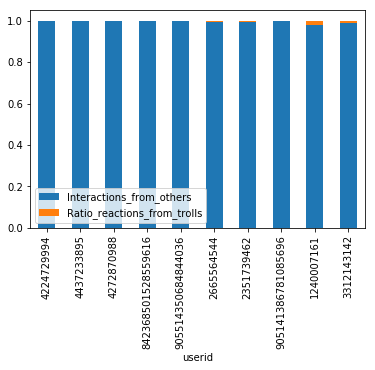

In [260]:
most_interacted_with = interactions_df.sort_values("Total_times_interacted_with",ascending=False).head(10)
most_interacted_with["Interactions_from_others"]= 1-most_interacted_with["Ratio_reactions_from_trolls"]
most_interacted_with[["Interactions_from_others","Ratio_reactions_from_trolls"]].plot.bar(stacked=True)

### Tweets by 

In [41]:
tweets_by_most_retweeting_users = most_retweeting_users.withColumnRenamed("userid","usrid")
tweets_by_most_retweeting_users = tweets_by_most_retweeting_users\
                                .join(stats, stats.userid == most_retweeting_users.usrid)\
                        .select("userid","tweetid")
tweets_by_most_retweeting_users = tweets_by_most_retweeting_users.groupBy("userid").agg(count('*')).\
                select("userid", col("Count(1)").alias("total_tweets")).sort(desc("total_tweets"))
tweets_by_most_retweeting_users = tweets_by_most_retweeting_users.join(most_retweeting_users,
                                                                       tweets_by_most_retweeting_users.userid ==
                                                                      most_retweeting_users.usrid)\
                                    .select("userid","total_tweets","retweets_of_trolls")

In [39]:
tweets_by_most_retweeting_users = tweets_by_most_retweeting_users.withColumn(
                                "Percentage", (col("retweets_of_trolls") /col("total_tweets"))).sort(desc("Percentage"))

                
tweets_by_most_retweeting_users.show()

+--------------------+------------+------------------+------------------+
|              userid|total_tweets|retweets_of_trolls|        Percentage|
+--------------------+------------+------------------+------------------+
|9bd87edcd300b276a...|         119|               118|0.9915966386554622|
|9304dbfe749ac1b87...|         106|               103|0.9716981132075472|
|ed18ded2abb68f0bc...|         116|               112|0.9655172413793104|
|9f08edeb78f6dee82...|         110|               106|0.9636363636363636|
|1bed07f5349b6e10b...|         108|               104|0.9629629629629629|
|dfee299ad7755c7ac...|         107|               103|0.9626168224299065|
|9d1a1ff4e8016ea1d...|         122|               117|0.9590163934426229|
|179019db26001208f...|         124|               118|0.9516129032258065|
|f81678fb42a6bae9c...|         121|               112|0.9256198347107438|
|4584ea5091944dd0d...|         125|               114|             0.912|
|7a139f4631e610230...|         118|   

In [ ]:
print(retweeted_users.count())
print(retweeted_users.filter("retweets_by_trolls >= 10").count())
print(retweeted_users.filter("retweets_by_trolls >= 100").count())
print(retweeted_users.filter("retweets_by_trolls >= 1000").count())
print(retweeted_users.filter("retweets_by_trolls >= 10000").count())

print(retweeting_users.count())
most_retweeting_users = retweeting_users.filter("retweets_of_trolls >= 100").withColumnRenamed("userid","usrid")
print(most_retweeting_users.count())
print(retweeting_users.filter("retweets_of_trolls >= 100").count())
most_retweeting_users.show(10)

# 4) Discussion of our project so far

## 4.1) Critique of own analysis and sources of potential error

For many of our tasks it is unclear whether one can say that this is an total accurate representation of russian meddling on twitter. We only have a data sample, and it is likely that some of these accounts were taken down, given up on by IRA or by other reasons are not as active through the total period. In, it shows a general trend of the activity.

Disclaimer: Many of the visualizations still needs major improvements. Especially part 3.2 and some of the early descriptive statistics.



## 4.2) Own thoughts of milestone 2


### 4.2.1) Thoughts regarding the data sets

**First dataset:**
The first data set had some features that initally was thought to be useful that ended up not being so much, especially region and language. This encoding was not fully correct, and we therefore had to use them much more careful than earlier believed. 
**Second dataset:**

Things got a little changed when we got the possibility to work with a second data set on Sunday 18th November. The new data set featured a bunch of new interesting features, as well as not being categorized in the same manner as the first. We have not been able to look too much into it yet, but we really like the idea of combining the two and then getting more data samples. Right now, the second dataset does not have that many features, but we will be adding some more that we think will be useful for further analysing.

### 4.2.2) Dropped ideas or changed approaches to them.
**Other languages**

We worked a while on trying to analyse some of the non-english tweets, in particular the european ones. It was a significant amount, especially of the german data, but we struggled to get something in particular out of it. In general text classification became harder than initially thought. 

**General text classification** 

We was originally going to do this regarding the question how someone could determine whethter a twitter account is a troll. We knew that the TextBlob library had the application to create a sentiment, subjectivity and polarization tweets. We applied this, but when we were visualizing it we found out that it did not work as we had hoped. We found out that many of the tweets were not giving values even though there were clear indication of negative speak or positive speak. We also saw that the library struggled when tweets were particulary short. 

**Concerning traits to look for whether a user is a troll**

We found out that many of the twitter users have irregular rhytms when it comes to followers and the update of them after tweeting. Some had sudden drops of hundreds of followers and following in just a few minutes, which may imply buying of fake or real followers (or own methods of phishing to get them). Others had irregular amounts of tweets in short time span, and also some users were sharing the same rhythm of the same tweets. Unfortunately we did not have time for analysing this in whole before the end of milestone 2.


# 5) Plan for the next milestone

Visualization:
- We are not pleased with the visualization at the moment, and want to increase our quality here.
- Look for other alternatives than used right now or effectively improve those we already have.

Modeling:
- Try to create a model that could determine which category each twitter user is. This may be difficult to manage, but the idea is to split the original dataset into a training and test set and create a model that could classify the different categories. Then apply this one the new one and see if it actually has made an improvement on the dataset and could be used as an actual classifier.

Perform the analysis regarding our most important research question - "Is there a way for people without a technical background to determine if a tweet is coming from a Russian troll?":
- Analyse followers and following to look deeper into the movement of this.
- Look at the frequency and patterns of the time the tweets were tweeted.

Improving the second data set:
- Add features similar to the original data set.
- Enrich the second data set by creating similar and new subsets.
- Look more into the interaction between trolls in the new set, since we also have the user ID of each tweet.

Create the data story:
- Look for suitable tools to create our data story in.
- Extract our most important findings and present something that actually provides meaningful insight to how the russian trolls operates.
- Search for and add features unique for the data story. Animations e.g.
- Finish the data story.

Create the poster:
- Sort out the visuals that works best in paper format, and choose the most interesting results for this.
